<a href="https://colab.research.google.com/github/ashwani-bhat/adversarial-attacks/blob/master/FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ashwani-bhat/adversarial-attacks.git

fatal: destination path 'adversarial-attacks' already exists and is not an empty directory.


#Basic CNN model

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [3]:
class Basic_CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Basic_CNN, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes

        self.conv1_1 = nn.Conv2d(self.in_channels, 32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(7*7*64, 200)
        self.fc2 = nn.Linear(200, self.num_classes)


    def forward(self, x):

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))

        x = self.maxpool1(x)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))

        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


#FGSM Attack (MNIST)

In [23]:
import torch
from torch.autograd import Variable
from torchvision import models
import torch.nn as nn
from torchvision import transforms
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

In [75]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--img', type=str, default='images/img_3.jpg', help='path to image')
# parser.add_argument('--y', type=int, required=False, help='Label')
# parser.add_argument('--gpu', action="store_true", default=False)

# args = parser.parse_args()
# image_path = args.img
# y_true = args.y
# gpu = args.gpu

image_path = 'adversarial-attacks/images/img_11.jpg'
IMG_SIZE = 28

In [76]:
orig = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
orig = cv2.resize(orig, (IMG_SIZE, IMG_SIZE))
img = orig.copy().astype(np.float32)
perturbation = np.empty_like(orig)

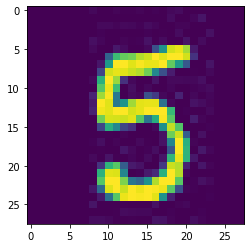

In [77]:
plt.imshow(orig)
plt.show()

In [78]:
mean = [0.5]
std = [0.5]
img /= 255.0
img = (img - mean)/std

In [79]:
# load model
model = Basic_CNN(1, 10)
saved = torch.load('adversarial-attacks/9920.pth.tar', map_location='cpu')
model.load_state_dict(saved['state_dict'])
model.eval()
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

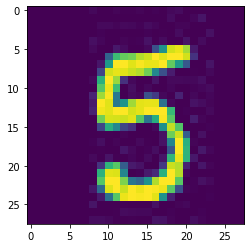

Prediction before attack: 5


In [80]:
# prediction before attack
inp = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0).unsqueeze(0), requires_grad=True)

out = model(inp)
pred = np.argmax(out.data.cpu().numpy())
plt.imshow(orig)
plt.show()
print('Prediction before attack: %s' %(pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


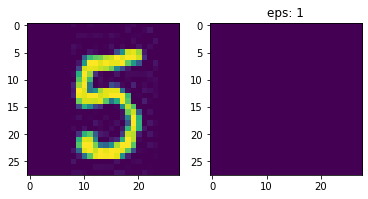

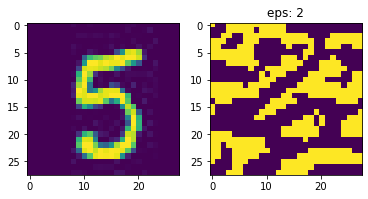

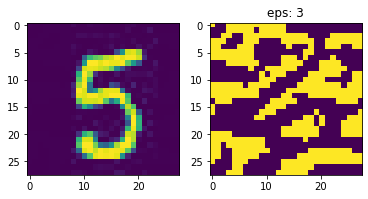

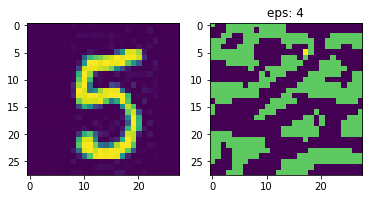

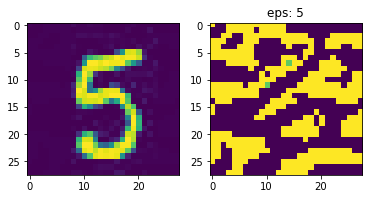

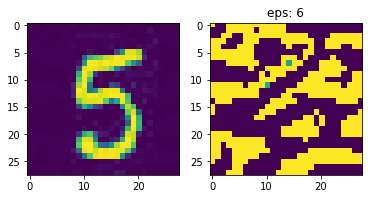

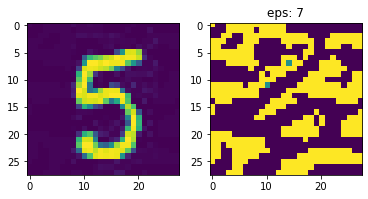

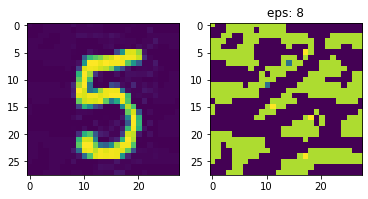

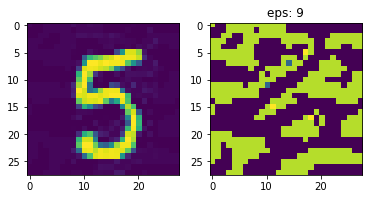

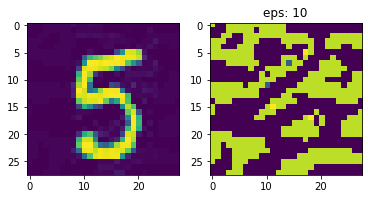

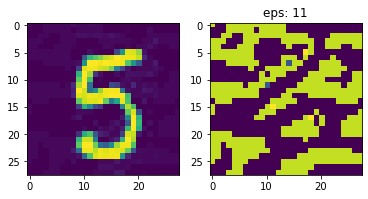

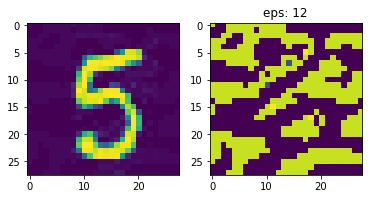

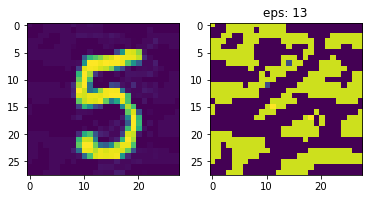

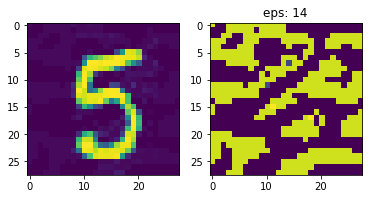

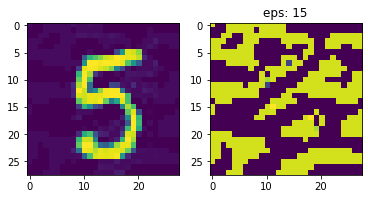

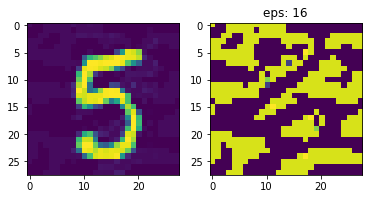

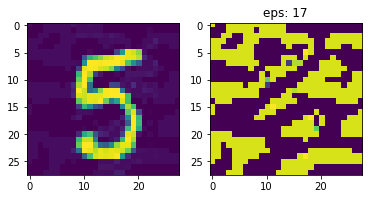

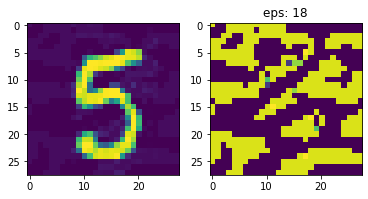

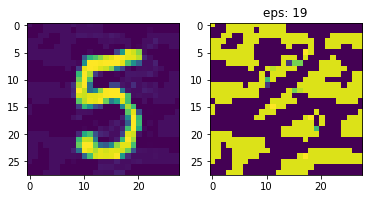

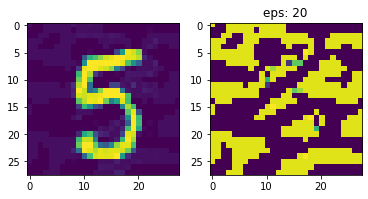

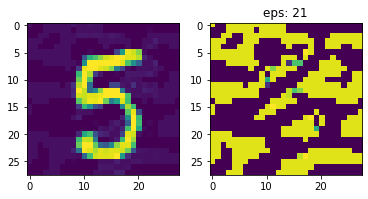

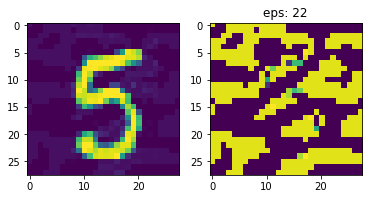

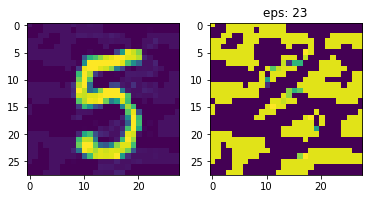

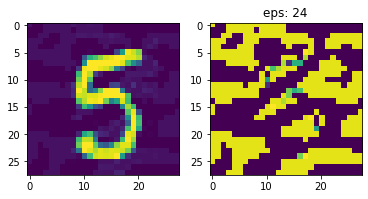

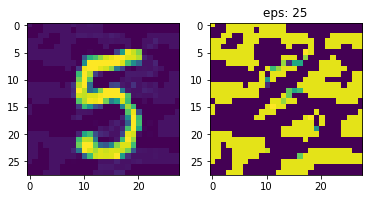

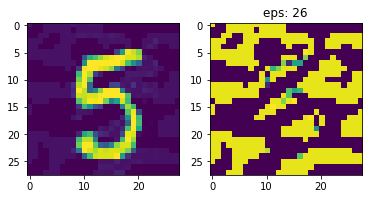

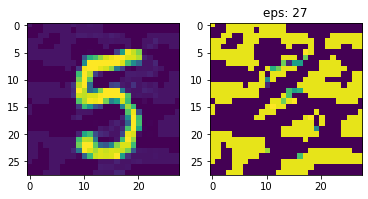

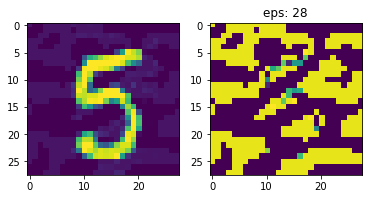

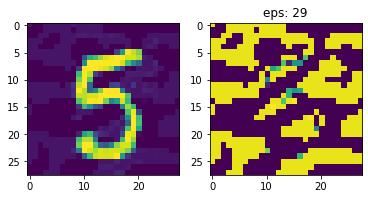

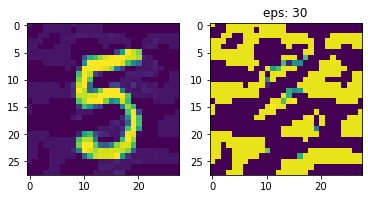

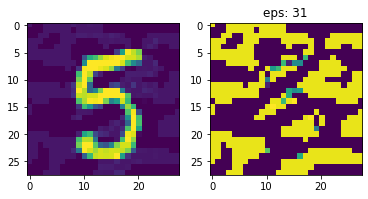

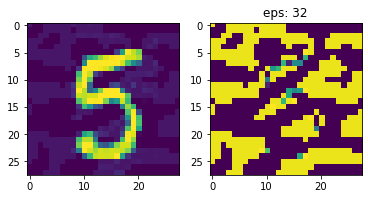

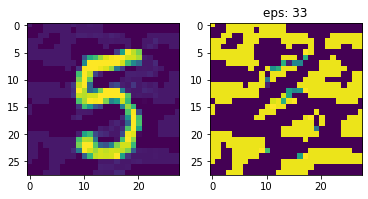

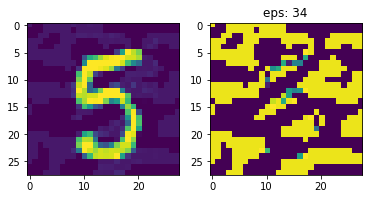

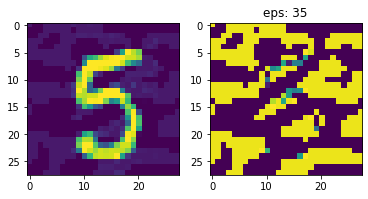

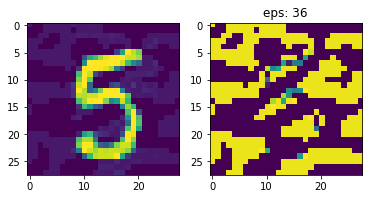

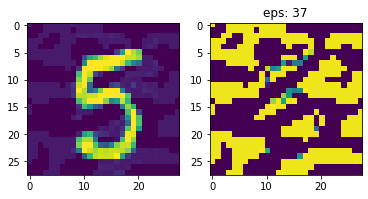

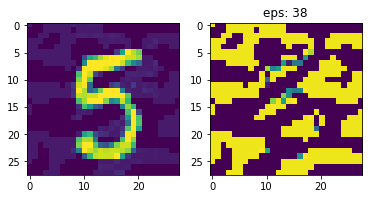

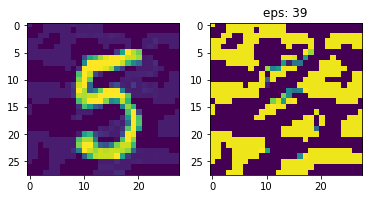

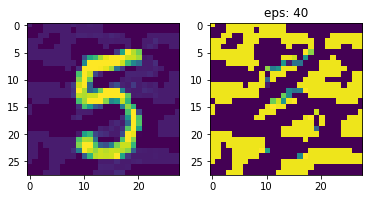

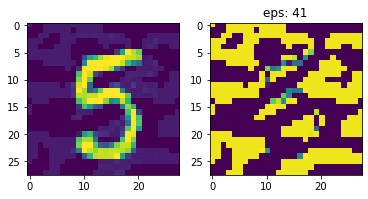

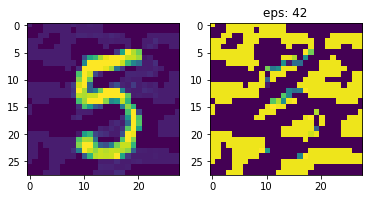

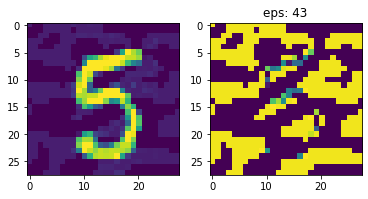

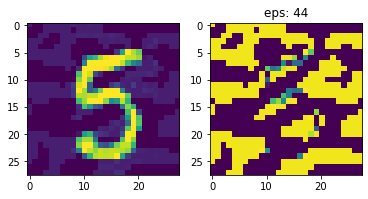

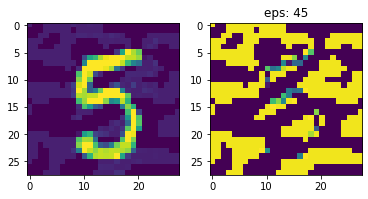

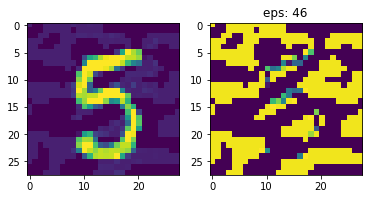

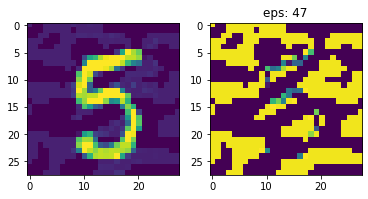

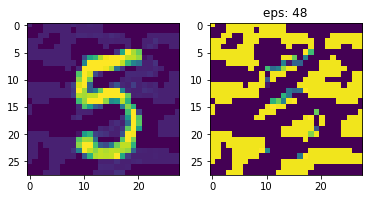

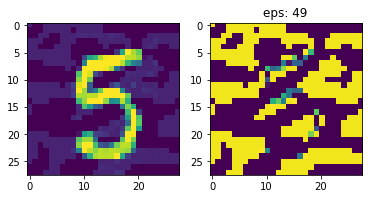

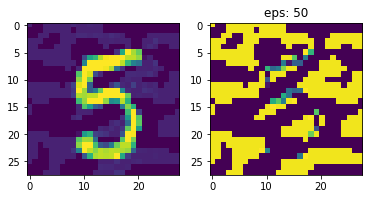

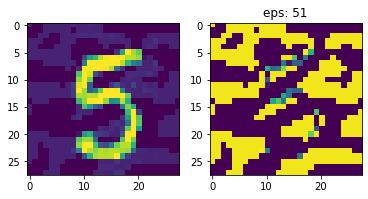

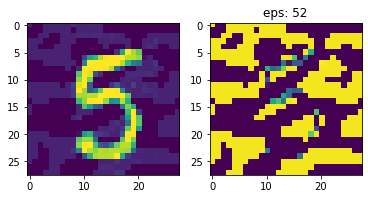

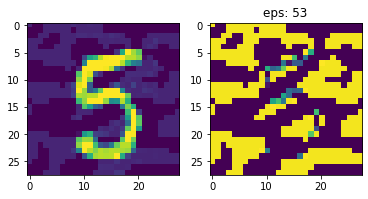

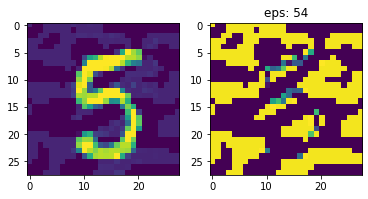

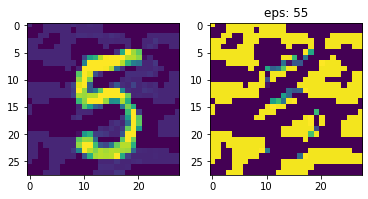

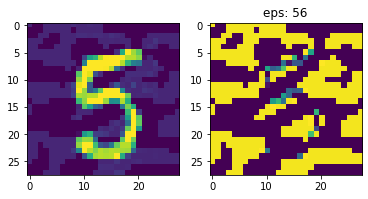

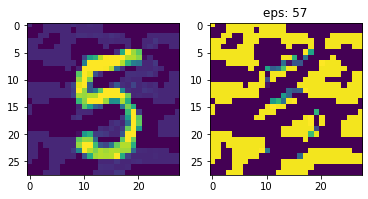

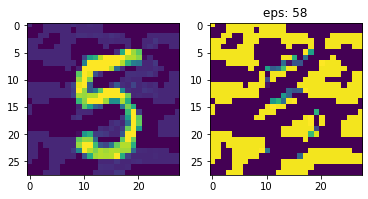

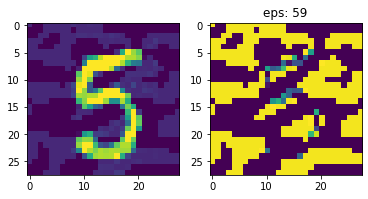

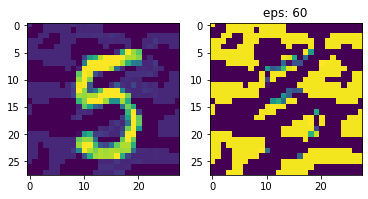

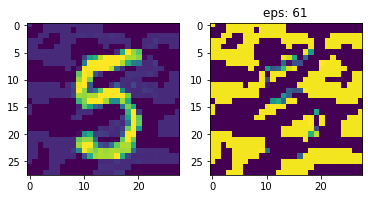

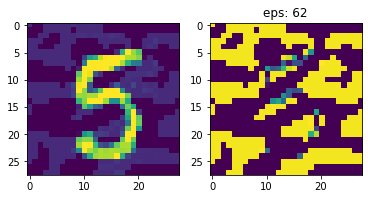

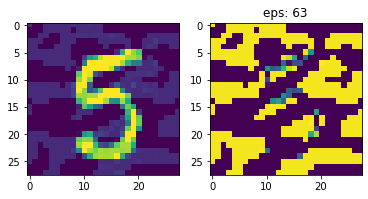

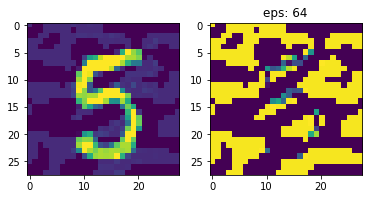

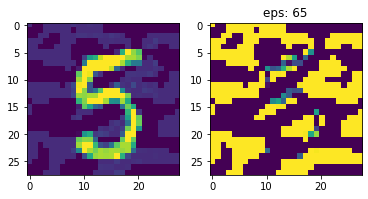

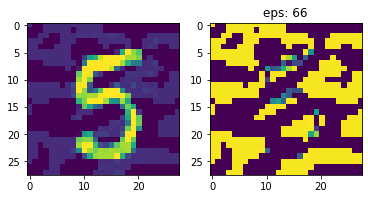

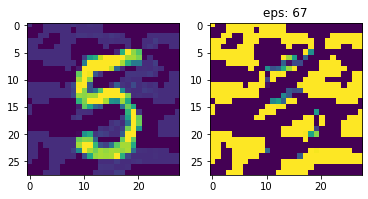

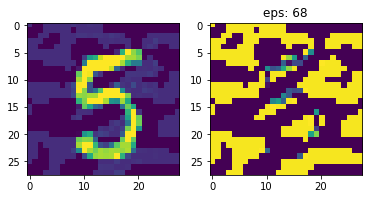

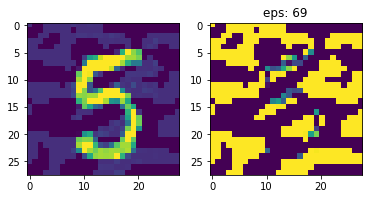

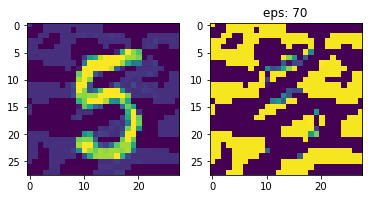

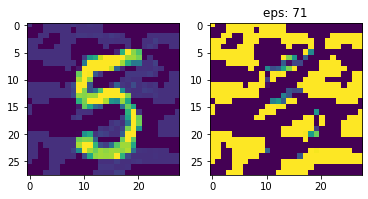

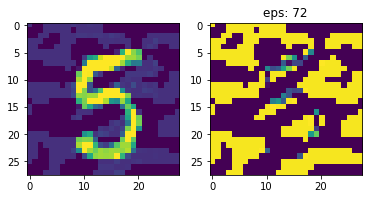

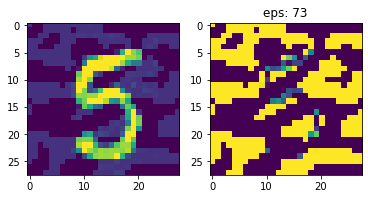

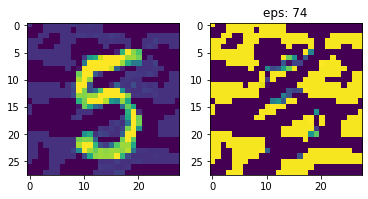

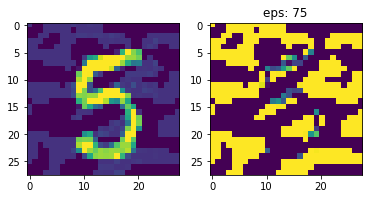

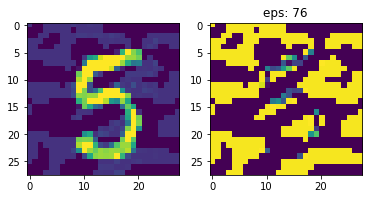

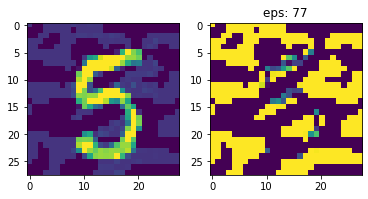

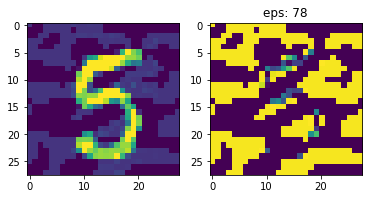

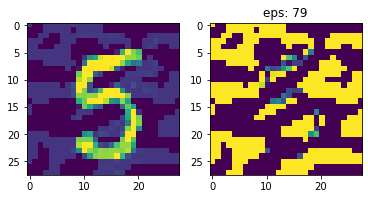

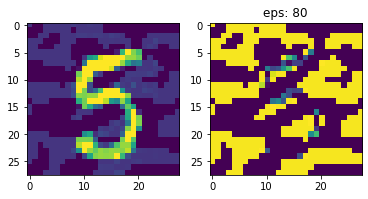

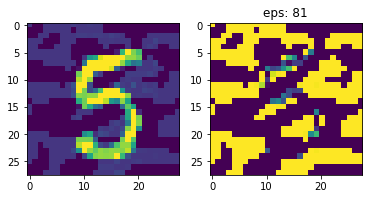

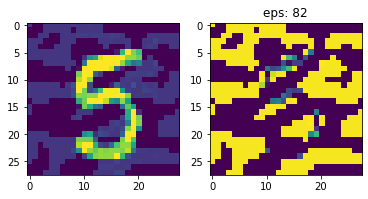

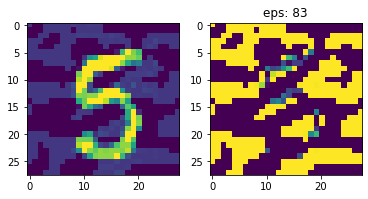

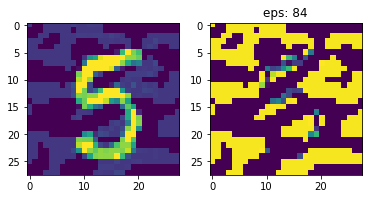

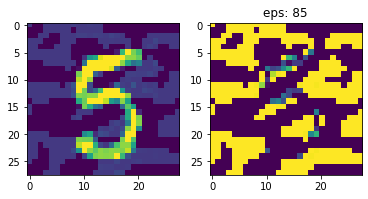

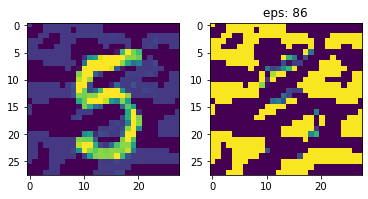

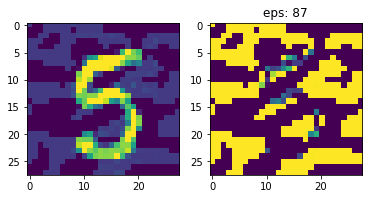

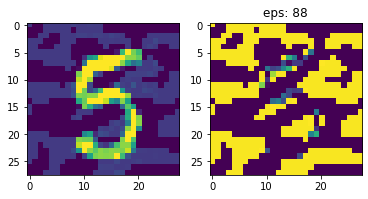

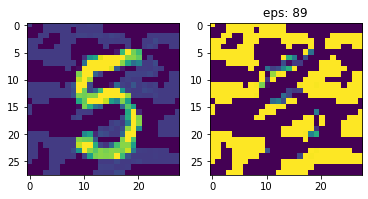

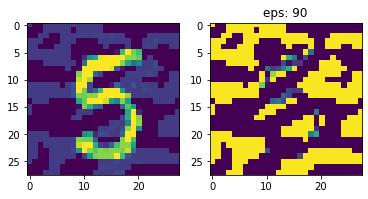

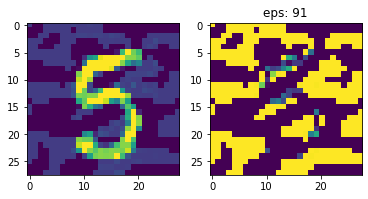

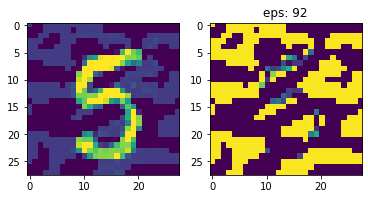

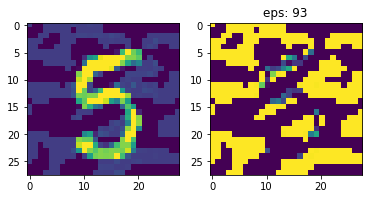

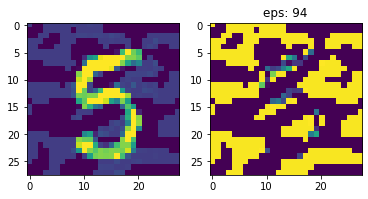

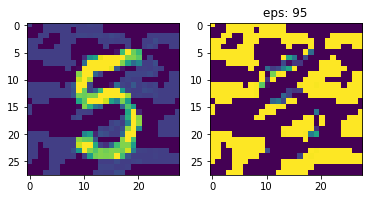

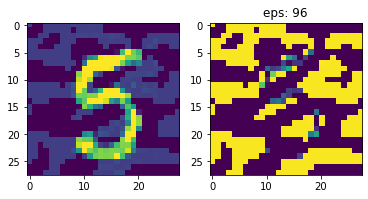

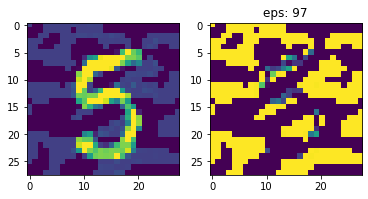

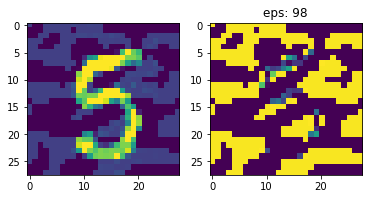

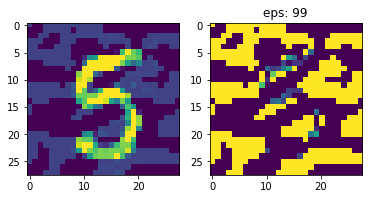

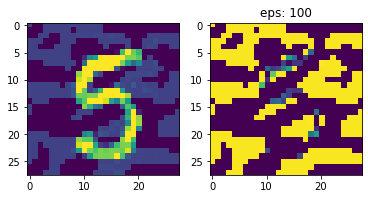

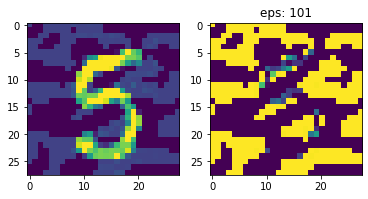

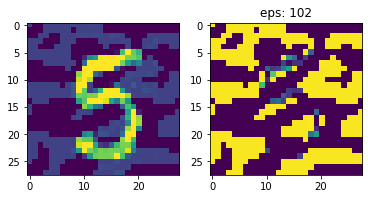

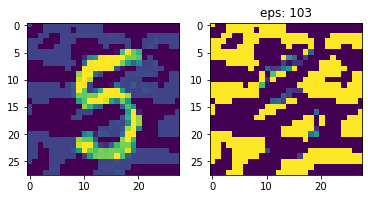

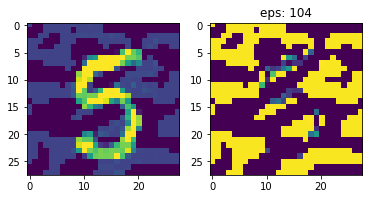

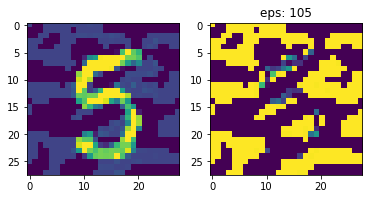

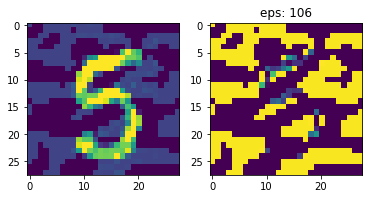

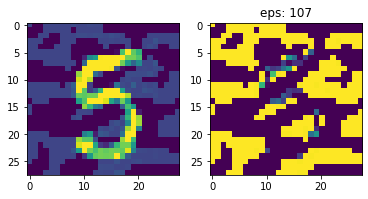

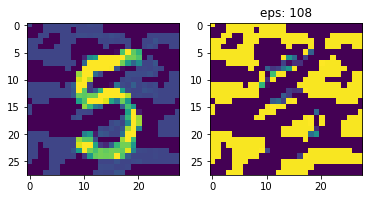

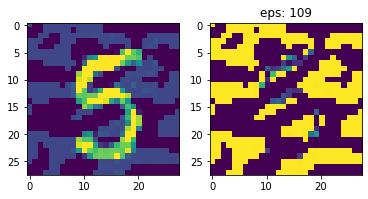

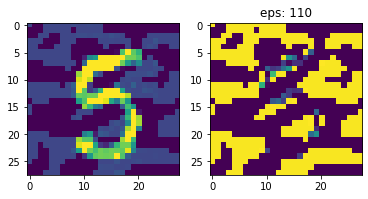

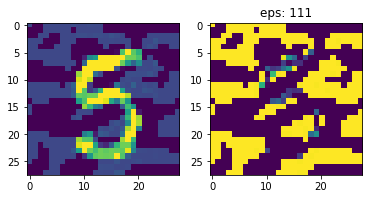

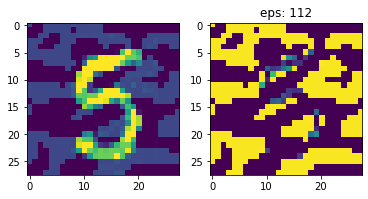

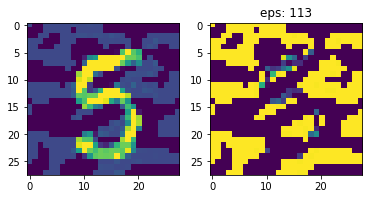

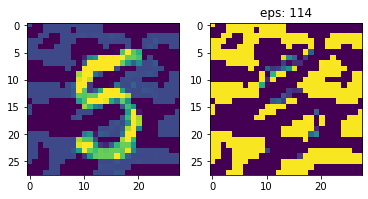

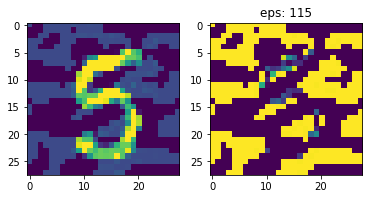

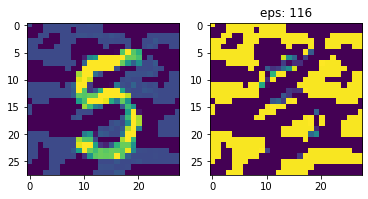

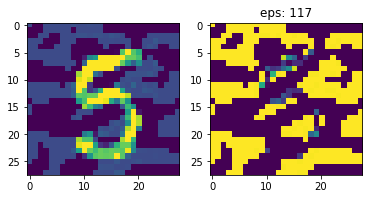

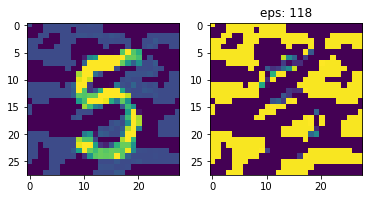

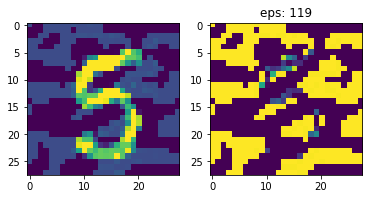

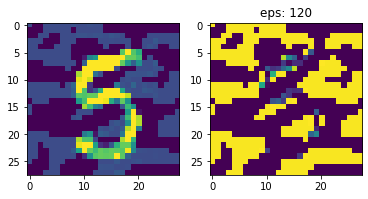

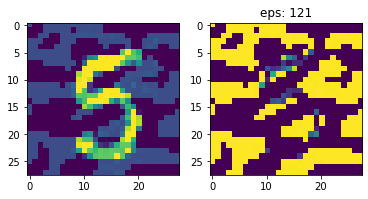

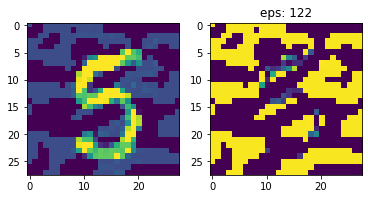

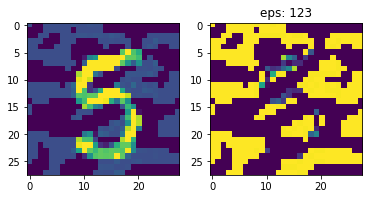

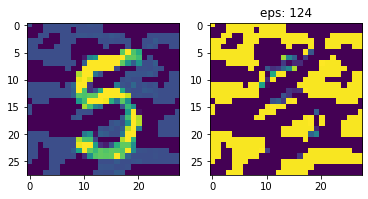

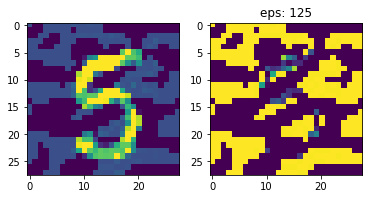

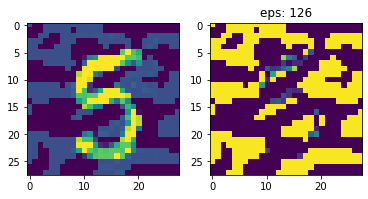

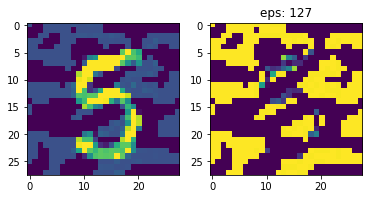

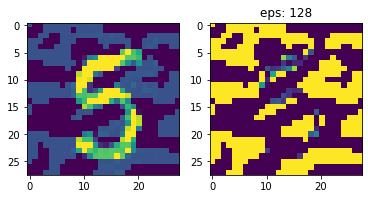

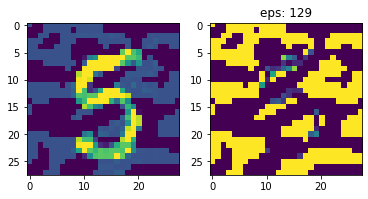

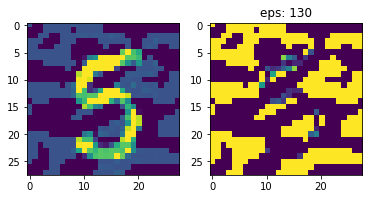

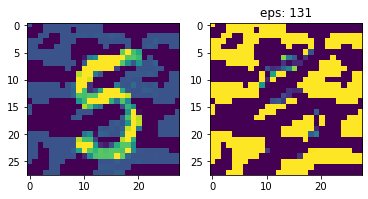

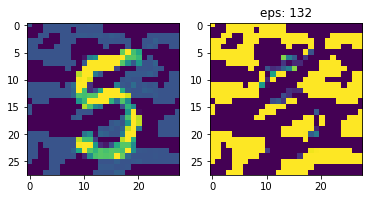

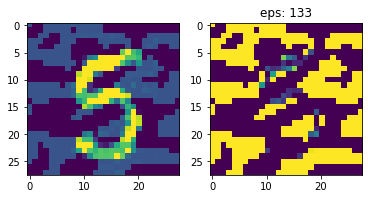

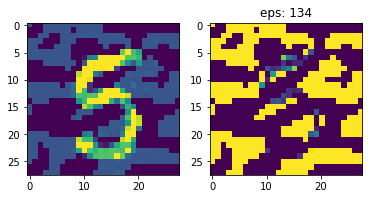

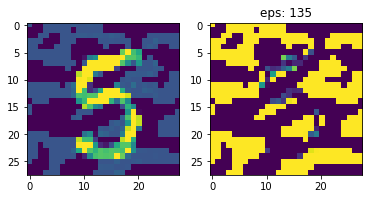

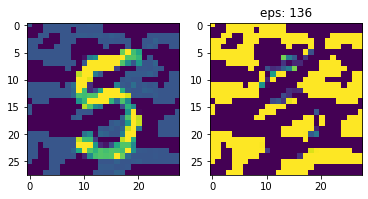

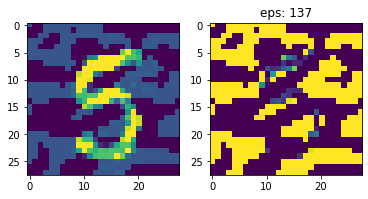

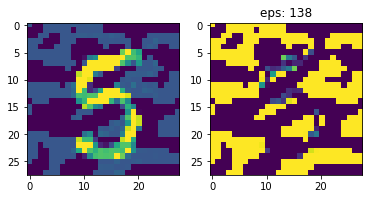

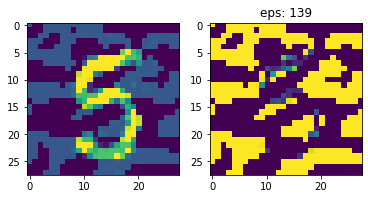

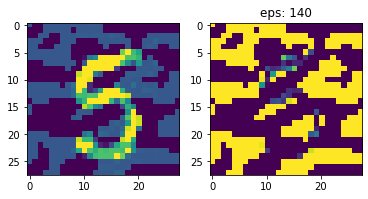

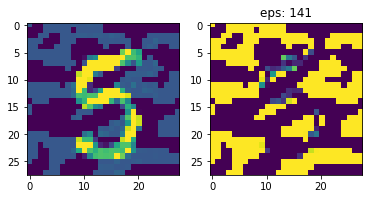

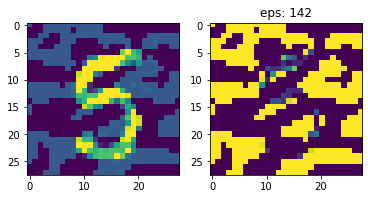

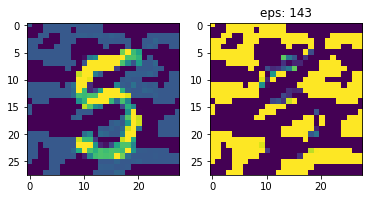

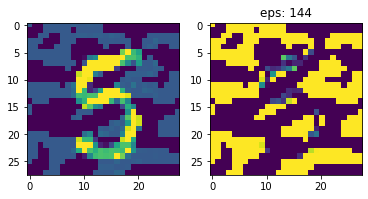

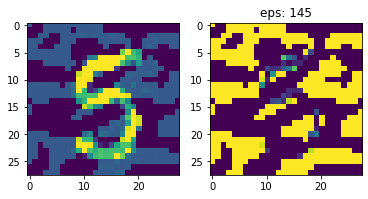

In [81]:
for eps in range(1, 146):
    inp = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0).unsqueeze(0), requires_grad=True)

    out = model(inp)
    loss = criterion(out, Variable(torch.Tensor([float(pred)]).to(device).long()))

    # compute gradients
    loss.backward()

    # not defined eps [originally taken from trackbar]

    # this is it, this is the method (fgsm)
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=-1, max=1)

    # predict on the adversarial image
    pred_adv = np.argmax(model(inp).data.cpu().numpy())
    print(" "*60, end='\r') 
    print("After attack: eps [%f] \t%s"
            %(eps, pred_adv), end="\r")


    # deprocess image
    adv = inp.data.cpu().numpy()[0][0]
    perturbation = adv-img
    adv = (adv * std) + mean
    adv = adv * 255.0
    adv = np.clip(adv, 0, 255).astype(np.uint8)
    perturbation = perturbation*255
    perturbation = np.clip(perturbation, 0, 255).astype(np.uint8)

    # display images
    f, axarr = plt.subplots(1,2)
    plt.title("eps: "+ str(eps))
    axarr[0].imshow(adv)
    axarr[1].imshow(perturbation)


#FGSM attack (ImageNet)